In [1]:
%load_ext autoreload
%autoreload 2
%autosave 60
%matplotlib inline
from ivanocode.ivanocommon import *
import pandas as pd

Autosaving every 60 seconds


In [2]:
df_sales_train_melt = pd.read_feather('df_sales_train_melt.feather')

In [3]:
df_sales_train_melt.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,day_id,sales,daily_avg_count,monthly_avg_count,day_date,day_date_str,month_id,month,year,date,wm_yr_wk,sell_price,sell_price_flip_count
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0.313643,9.409305,2011-01-29,2011-01-29,1,1,2011,2011-01-29,11101,NaN,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0.257710,7.731312,2011-01-29,2011-01-29,1,1,2011,2011-01-29,11101,NaN,1


In [4]:
df_sales_train_melt['id'].nunique()

30490

In [5]:
sample_ids = df_sales_train_melt['id'].unique()[0:10]

In [6]:
df_sample = df_sales_train_melt.query('id in @sample_ids').copy()

In [7]:
# needed for the feather
df_sample.reset_index(drop=True, inplace=True)

In [8]:
df_sample.to_feather('df_sales_train_melt_sample100series.feather')

In [9]:
len(df_sample)

19130

In [10]:
from fastai.tabular import *

In [11]:
day_ids = list(sorted(df_sample['day_id'].unique()))
len(day_ids)

1913

In [12]:
valid_idx = np.flatnonzero(df_sample['day_id'] > 1800)

In [13]:
procs = [FillMissing, Categorify, Normalize]
dep_var = 'sales'
cat_names = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'month_id', 'id']
# TODO: see what else other than SNAP's and holidays is missing from the original data
cols = cat_names + ['sell_price'] + [dep_var]

In [14]:
# otherwise we'll get a classifier out of this
df_sample[dep_var] = df_sample[dep_var].astype('float64')

In [15]:
path ='./tmp'
# TODO: check how dates with no sales are represented
data = TabularDataBunch.from_df(path, df_sample[cols], dep_var, valid_idx=valid_idx,
                                procs=procs, cat_names=cat_names)

In [16]:
data

TabularDataBunch;

Train: LabelList (18000 items)
x: TabularList
item_id HOBBIES_1_001; dept_id HOBBIES_1; cat_id HOBBIES; store_id CA_1; state_id CA; month_id 1; id HOBBIES_1_001_CA_1_validation; sell_price_na True; sell_price -0.1605; ,item_id HOBBIES_1_002; dept_id HOBBIES_1; cat_id HOBBIES; store_id CA_1; state_id CA; month_id 1; id HOBBIES_1_002_CA_1_validation; sell_price_na True; sell_price -0.1605; ,item_id HOBBIES_1_003; dept_id HOBBIES_1; cat_id HOBBIES; store_id CA_1; state_id CA; month_id 1; id HOBBIES_1_003_CA_1_validation; sell_price_na True; sell_price -0.1605; ,item_id HOBBIES_1_004; dept_id HOBBIES_1; cat_id HOBBIES; store_id CA_1; state_id CA; month_id 1; id HOBBIES_1_004_CA_1_validation; sell_price_na True; sell_price -0.1605; ,item_id HOBBIES_1_005; dept_id HOBBIES_1; cat_id HOBBIES; store_id CA_1; state_id CA; month_id 1; id HOBBIES_1_005_CA_1_validation; sell_price_na True; sell_price -0.1605; 
y: FloatList
0.0,0.0,0.0,0.0,0.0
Path: tmp;

Valid: LabelList (1130 it

In [17]:
sales_range = df_sales_train_melt.agg({'sales': ['min', 'max']})
sales_range

,sales
min,0
max,763


In [18]:
def mois_accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1).float() # doesn't appreciate ints here :/
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

learn = tabular_learner(data, layers=[200,100], emb_szs=None, metrics=mois_accuracy, 
                        y_range=sales_range['sales'].values)
learn.lr_find()

epoch,train_loss,valid_loss,mois_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


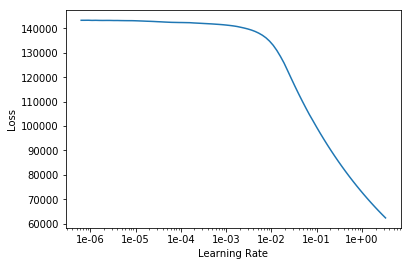

In [19]:
learn.recorder.plot()

In [20]:
# when trained as a classifier accuracy was on the order of 0.58 in 2nd epoch
learn.fit_one_cycle(1, 1e0)

epoch,train_loss,valid_loss,mois_accuracy,time
0,50.643024,27.602495,0.558407,00:34


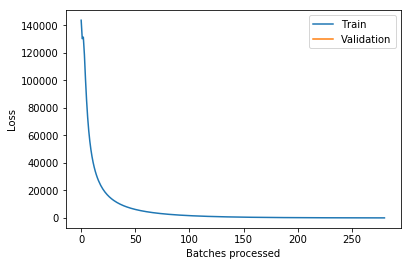

In [21]:
learn.recorder.plot_losses()

In [22]:
# 8865760240
# df_sales_train_melt.values.nbytes

epoch,train_loss,valid_loss,mois_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


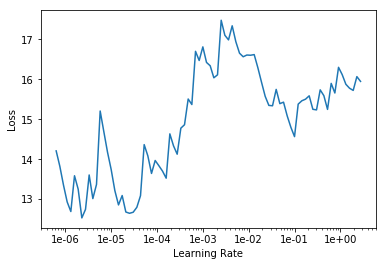

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
df_sales_train_melt['day_date'].max()

Timestamp('2016-04-24 00:00:00')

In [25]:
df_sample_submission = pd.read_csv('raw/sample_submission.csv')
df_sample_submission.head()
from datetime import timedelta
d_1_date = pd.to_datetime(df_sales_train_melt['day_date'].max())
mapping = {f'F{day}':(d_1_date + timedelta(days=day)).date() for day in range(1,29)}
mapping['id'] = 'id'
# TODO: sell_price should come from last sales day
df_sample_submission.columns = df_sample_submission.columns.map(mapping)
df_sample_submission_melt = df_sample_submission.melt(id_vars='id', var_name='day', value_name='sales')
df_sample_submission_melt.head(1)

,id,day,sales
0,HOBBIES_1_001_CA_1_validation,2016-04-25,0


In [26]:
last_prices = df_sales_train_melt[['id', 'sell_price']].groupby('id').tail(1)
last_prices.head(1)

,id,sell_price
58296880,HOBBIES_1_001_CA_1_validation,8.38


In [27]:
df_sample_submission_melt = df_sample_submission_melt.merge(
    last_prices, on='id', how='left', validate='many_to_one')

In [28]:
t = df_sample_submission_melt.head(100).copy()
t.head()

,id,day,sales,sell_price
0,HOBBIES_1_001_CA_1_validation,2016-04-25,0,8.38
1,HOBBIES_1_002_CA_1_validation,2016-04-25,0,3.97
2,HOBBIES_1_003_CA_1_validation,2016-04-25,0,2.97
3,HOBBIES_1_004_CA_1_validation,2016-04-25,0,4.64
4,HOBBIES_1_005_CA_1_validation,2016-04-25,0,2.88


In [29]:
df_sales_train_melt.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,day_id,sales,daily_avg_count,monthly_avg_count,day_date,day_date_str,month_id,month,year,date,wm_yr_wk,sell_price,sell_price_flip_count
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0.313643,9.409305,2011-01-29,2011-01-29,1,1,2011,2011-01-29,11101,NaN,1


In [30]:
def extract_id_columns(t):
    extracted = t['id'].str.extract('([A-Z]+)_(\\d)_(\\d{3})_([A-Z]{2})_(\d)')
    t['cat_id'] = extracted[0]
    t['dept_id'] = t['cat_id'] + '_' + extracted[1]
    t['item_id'] = t['cat_id'] + '_' + extracted[2]
    t['state_id'] = extracted[3]
    t['store_id'] = t['state_id'] + '_' + extracted[4]
    return t

extract_id_columns(t).head(1)

,id,day,sales,sell_price,cat_id,dept_id,item_id,state_id,store_id
0,HOBBIES_1_001_CA_1_validation,2016-04-25,0,8.38,HOBBIES,HOBBIES_1,HOBBIES_001,CA,CA_1


In [31]:
df_sample_submission_melt = extract_id_columns(df_sample_submission_melt)

In [32]:
df_sample_submission_melt['month_id'] = pd.to_datetime(df_sample_submission_melt['day']).dt.month
df_sample_submission_melt[dep_var] = df_sample_submission_melt[dep_var].astype('float64')

In [33]:
learn.data.add_test(TabularList.from_df(df=df_sample_submission_melt, 
                                        cat_names=cat_names, 
                                        cont_names=learn.data.train_ds.x.cont_names,
                                        processor = learn.data.train_ds.x.processor))

In [34]:
preds, y = learn.get_preds(DatasetType.Test)

In [35]:
# Note to self: this looked like a trained classifier at first :D
preds.size()

torch.Size([1707440, 1])

In [36]:
learn

Learner(data=TabularDataBunch;

Train: LabelList (18000 items)
x: TabularList
item_id HOBBIES_1_001; dept_id HOBBIES_1; cat_id HOBBIES; store_id CA_1; state_id CA; month_id 1; id HOBBIES_1_001_CA_1_validation; sell_price_na True; sell_price -0.1605; ,item_id HOBBIES_1_002; dept_id HOBBIES_1; cat_id HOBBIES; store_id CA_1; state_id CA; month_id 1; id HOBBIES_1_002_CA_1_validation; sell_price_na True; sell_price -0.1605; ,item_id HOBBIES_1_003; dept_id HOBBIES_1; cat_id HOBBIES; store_id CA_1; state_id CA; month_id 1; id HOBBIES_1_003_CA_1_validation; sell_price_na True; sell_price -0.1605; ,item_id HOBBIES_1_004; dept_id HOBBIES_1; cat_id HOBBIES; store_id CA_1; state_id CA; month_id 1; id HOBBIES_1_004_CA_1_validation; sell_price_na True; sell_price -0.1605; ,item_id HOBBIES_1_005; dept_id HOBBIES_1; cat_id HOBBIES; store_id CA_1; state_id CA; month_id 1; id HOBBIES_1_005_CA_1_validation; sell_price_na True; sell_price -0.1605; 
y: FloatList
0.0,0.0,0.0,0.0,0.0
Path: tmp;

Valid: Label

In [37]:
import matplotlib.pyplot as plt

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x55589b8d0>]], dtype=object)

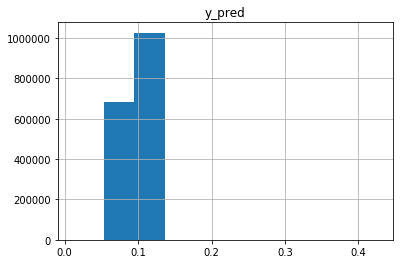

In [40]:
df_preds = pd.DataFrame({'y_pred': preds.reshape(len(preds))})
df_preds.hist()

In [44]:
df_preds['y_pred'].value_counts()

0.095800    54362
0.095799    54340
0.095281    54318
0.095771    35332
0.095770    35156
            ...  
0.089687        6
0.088662        6
0.088662        6
0.088660        6
0.090039        6
Name: y_pred, Length: 37659, dtype: int64

In [43]:
df_preds['y_pred'].value_counts().sort_index()

0.011820     6
0.012162    22
0.020142    22
0.021582     6
0.024631     6
            ..
0.121404     6
0.153891    22
0.154455     6
0.375962    22
0.426164     6
Name: y_pred, Length: 37659, dtype: int64

In [42]:
len(df_preds['y_pred'])

1707440